# Analyse a Forecast on Target, Related and Item Meta Dataset
* **About 10 mins may be elapsed**

In [1]:
import boto3
from time import sleep
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
%store -r

In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

## Obtaining the forecast results from S3

In [15]:
import os
prophet_result_dir = "prophet" + suffix
deepar_result_dir = "deeparp" + suffix
! mkdir -p {prophet_result_dir} # Create a folder for prophet forecast result
! mkdir -p {deepar_result_dir}

In [17]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" +  "prophet_" + item_meta_suffix + suffix
prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print("prophet_files: ", prophet_files)
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, prophet_result_dir+"/"+prophet_filename)
# print(prophet_filename)

In [18]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" + "deeparp_" + item_meta_suffix + suffix
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix=prefix))
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, deepar_result_dir+"/"+deeparp_filename)
# print(deeparp_filename)

In [19]:
def getTotalForecastResult(resultFolder):
    """
    Return a dataframe containing all forecast files in the folder passed
    """
    total_predicts_s3 = pd.DataFrame()
    for file in os.listdir(resultFolder):
        predicts_s3 = pd.read_csv(resultFolder + "/" + file)
        total_predicts_s3 = total_predicts_s3.append(predicts_s3)
    return total_predicts_s3
    
prophet_predicts_s3 = getTotalForecastResult(prophet_result_dir)    
deeparp_predicts_s3 = getTotalForecastResult(deepar_result_dir)    


In [20]:
# Remove the folders already used
! rm -rf {prophet_result_dir}
! rm -rf {deepar_result_dir}

## Load forecast results from local folder 

In [21]:
prophet_predicts_s3.info()
deeparp_predicts_s3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 6 columns):
item_id      585 non-null int64
StoreType    585 non-null object
date         585 non-null object
p10          585 non-null float64
p50          585 non-null float64
p90          585 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 27.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 6 columns):
item_id      585 non-null int64
StoreType    585 non-null object
date         585 non-null object
p10          585 non-null float64
p50          585 non-null float64
p90          585 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 27.5+ KB


In [22]:
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts.head()

,item_id,StoreType,date,p10,p50,p90
0,7,b,2012-07-30T00:00:00Z,646352.197001,706740.129503,769146.561914
1,7,b,2012-08-06T00:00:00Z,648764.760489,721543.254673,794775.128417
2,7,b,2012-08-13T00:00:00Z,636945.845592,701829.952017,769203.820302
3,7,b,2012-08-20T00:00:00Z,623981.527967,681683.807694,739579.480350
4,7,b,2012-08-27T00:00:00Z,602897.699226,665120.031290,729114.918780


In [23]:
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date']) 
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None) # Convert time zone
prophet_predicts.date = pd.to_datetime(prophet_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
prophet_predicts.item_id = prophet_predicts.item_id.astype(str) # convert to string type
prophet_predicts = prophet_predicts[['date','item_id','p10', 'p50', 'p90']]
prophet_predicts.head()

,date,item_id,p10,p50,p90
0,2012-07-30,7,646352.197001,706740.129503,769146.561914
1,2012-08-06,7,648764.760489,721543.254673,794775.128417
2,2012-08-13,7,636945.845592,701829.952017,769203.820302
3,2012-08-20,7,623981.527967,681683.807694,739579.480350
4,2012-08-27,7,602897.699226,665120.031290,729114.918780


In [24]:
# Remove the timezone
deeparp_predicts = deeparp_predicts_s3.copy()
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date']) 
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None) # Convert time zone
deeparp_predicts.date = pd.to_datetime(deeparp_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
deeparp_predicts.item_id = deeparp_predicts.item_id.astype(str) # convert to string type
deeparp_predicts = deeparp_predicts[['date','item_id','p10', 'p50', 'p90']]
deeparp_predicts.head()

,date,item_id,p10,p50,p90
0,2012-07-30,7,554112.50000,600598.4375,648833.0000
1,2012-08-06,7,541753.87500,599021.2500,660497.6875
2,2012-08-13,7,541271.56250,601718.3750,643680.1250
3,2012-08-20,7,524227.21875,582144.3125,629341.1250
4,2012-08-27,7,535805.00000,592324.1250,631795.0625


## Prepare validation file

In [25]:
validation_df = validation_stores_sales.copy()
validation_df.reset_index(inplace=True) # reset index
validation_df = validation_df.rename(columns={'index':'date'}) # Change column name to date
validation_df.date = pd.to_datetime(validation_df.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
validation_df.head()



,date,Weekly_Sales,item_id
0,2010-02-08,1643690.90,1
1,2010-02-15,1641957.44,1
2,2010-02-22,1611968.17,1
3,2010-03-01,1409727.59,1
4,2010-03-08,1554806.68,1


## Join forecast results with validation data

In [26]:
prophet_val_df = pd.merge(prophet_predicts,validation_df, 
#                           on=['date', 'item_id'], 
                          on=['date', 'item_id'], 
                          how='inner')
                          
prophet_val_df.set_index('date', inplace=True)
prophet_val_df.head(10)

,item_id,p10,p50,p90,Weekly_Sales
date,,,,,
2012-07-30,7,646352.197001,706740.129503,769146.561914,686365.40
2012-08-06,7,648764.760489,721543.254673,794775.128417,680954.81
2012-08-13,7,636945.845592,701829.952017,769203.820302,675926.30
2012-08-20,7,623981.527967,681683.807694,739579.480350,642450.40
2012-08-27,7,602897.699226,665120.031290,729114.918780,609099.37
2012-09-03,7,597451.000735,655415.013946,724786.024448,586467.16
2012-09-10,7,587125.590635,642388.479902,699731.535326,597876.55
2012-09-17,7,543754.480183,605711.567043,664335.902794,541120.20
2012-09-24,7,509671.233610,581927.162820,636699.438685,530842.25


In [27]:
deeparp_val_df = pd.merge(deeparp_predicts,validation_df, 
#                           on=['date', 'item_id'], 
                          on=['date', 'item_id'], 
                          how='inner')
                          
deeparp_val_df.set_index('date', inplace=True)
deeparp_val_df.head(10)

,item_id,p10,p50,p90,Weekly_Sales
date,,,,,
2012-07-30,7,554112.50000,600598.4375,648833.0000,686365.40
2012-08-06,7,541753.87500,599021.2500,660497.6875,680954.81
2012-08-13,7,541271.56250,601718.3750,643680.1250,675926.30
2012-08-20,7,524227.21875,582144.3125,629341.1250,642450.40
2012-08-27,7,535805.00000,592324.1250,631795.0625,609099.37
2012-09-03,7,520567.56250,570219.0625,630339.8750,586467.16
2012-09-10,7,514832.56250,579280.8125,643098.8750,597876.55
2012-09-17,7,501367.46875,576932.9375,661078.8750,541120.20
2012-09-24,7,532694.43750,572332.0625,631704.6250,530842.25


## MAPE metric for Prophet and DeepARP

In [28]:
prophet_val_metric_df = prophet_val_df.copy()
n_rows = prophet_val_metric_df.shape[0]
prophet_val_metric_df['mape_p50'] = (abs(prophet_val_metric_df.Weekly_Sales - prophet_val_metric_df.p50) / prophet_val_metric_df.Weekly_Sales ) 
print("prophet MAPE: ", prophet_val_metric_df['mape_p50'].mean())
prophet_val_metric_df.head(4)


prophet MAPE:  0.048229050243876755


,item_id,p10,p50,p90,Weekly_Sales,mape_p50
date,,,,,,
2012-07-30,7,646352.197001,706740.129503,769146.561914,686365.40,0.029685
2012-08-06,7,648764.760489,721543.254673,794775.128417,680954.81,0.059605
2012-08-13,7,636945.845592,701829.952017,769203.820302,675926.30,0.038323
2012-08-20,7,623981.527967,681683.807694,739579.480350,642450.40,0.061068


In [29]:
deeparp_val_metric_df = deeparp_val_df.copy()
n_rows = deeparp_val_metric_df.shape[0]
deeparp_val_metric_df['mape_p50'] = (abs(deeparp_val_metric_df.Weekly_Sales - deeparp_val_metric_df.p50) / deeparp_val_metric_df.Weekly_Sales ) 
# prophet_val_metric_df.head(200)
print("deeparp: ", deeparp_val_metric_df['mape_p50'].mean())
deeparp_val_metric_df.head(4)

deeparp:  0.051977782986420695


,item_id,p10,p50,p90,Weekly_Sales,mape_p50
date,,,,,,
2012-07-30,7,554112.50000,600598.4375,648833.0000,686365.40,0.124958
2012-08-06,7,541753.87500,599021.2500,660497.6875,680954.81,0.120322
2012-08-13,7,541271.56250,601718.3750,643680.1250,675926.30,0.109787
2012-08-20,7,524227.21875,582144.3125,629341.1250,642450.40,0.093869


#### An example of single forecast

In [34]:
forecast_query_response = forecast_query.query_forecast(
    ForecastArn = item_meta_prophet_forecast_arn,
    StartDate = "2012-08-01T00:00:00",
    EndDate = "2012-08-31T00:00:00",
    Filters={"item_id": "1"}
)
forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2012-08-06T00:00:00',
     'Value': 1459426.75},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1441227.5},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1479050.75},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1482017.75}],
   'p50': [{'Timestamp': '2012-08-06T00:00:00', 'Value': 1595398.125},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1568491.0},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1605328.875},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1628994.375}],
   'p90': [{'Timestamp': '2012-08-06T00:00:00', 'Value': 1730038.25},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1688820.75},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1737696.875},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1744750.25}]}},
 'ResponseMetadata': {'RequestId': '7f45f18b-21a1-4008-b08d-2190e9547174',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 05 

## Analyse prophet and deepar+ for all stores

In [35]:
from utils import show_two_chart_horizontal

item_id    int64
dtype: object


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


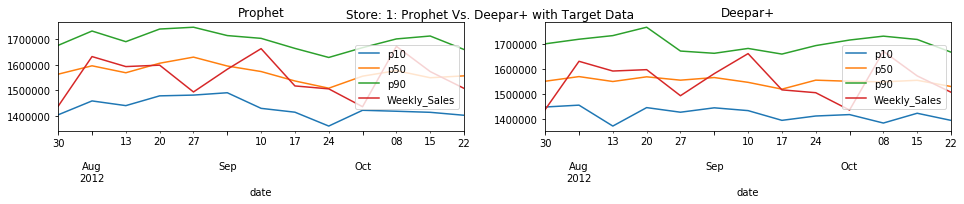

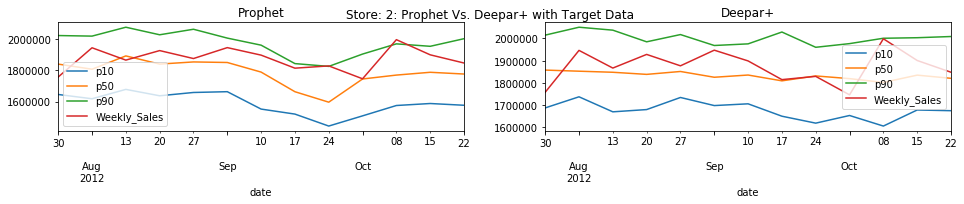

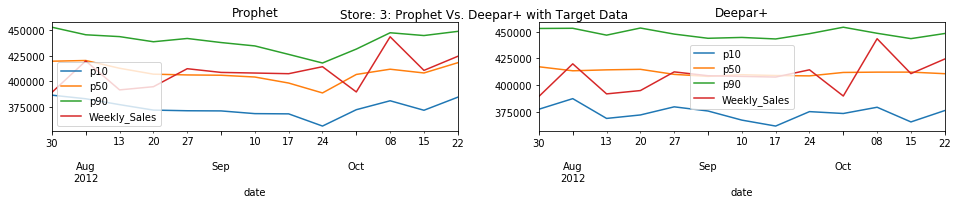

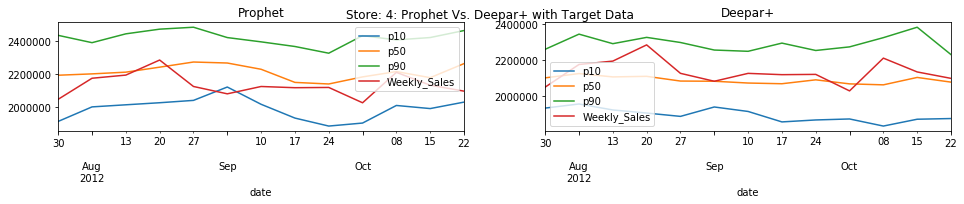

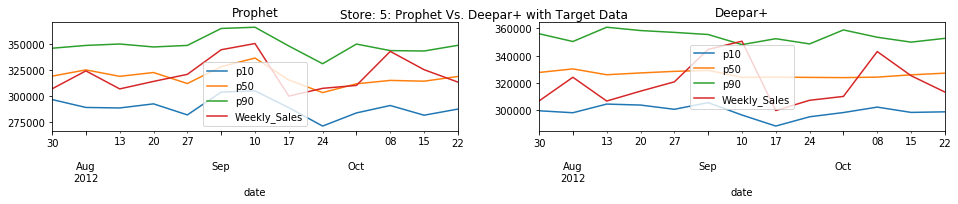

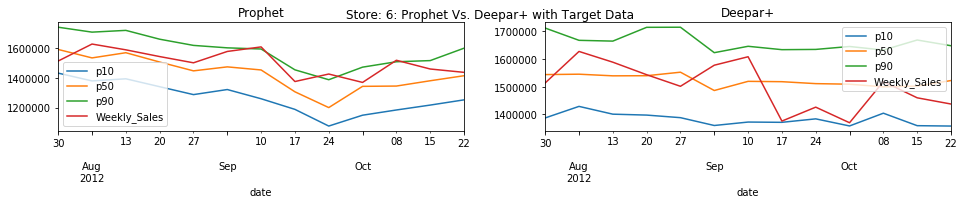

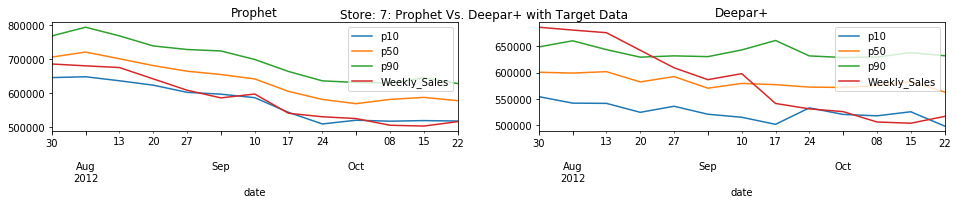

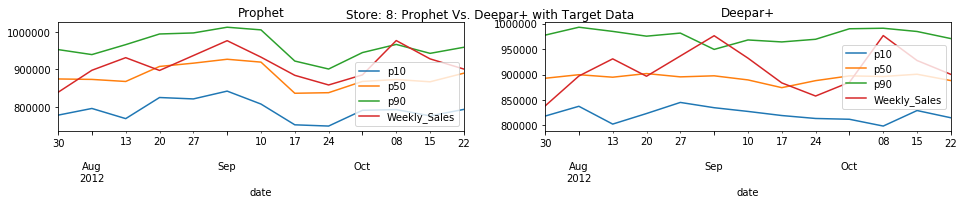

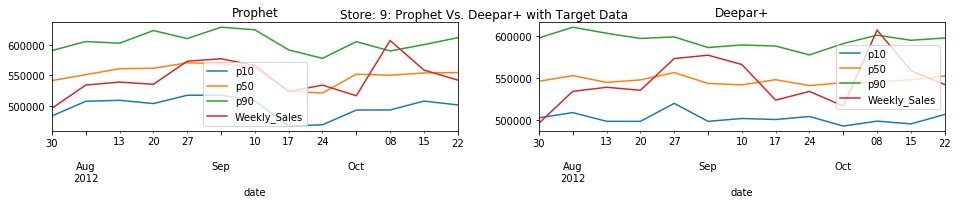

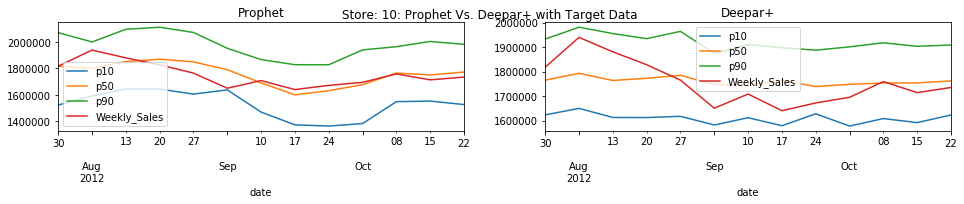

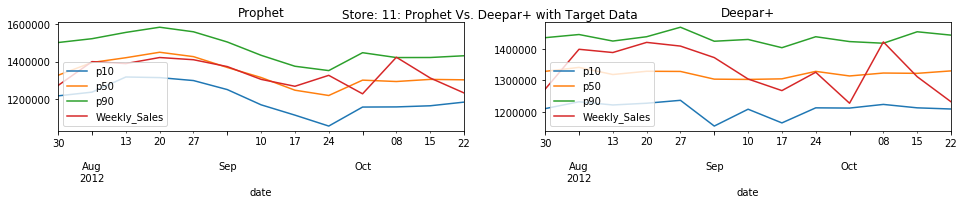

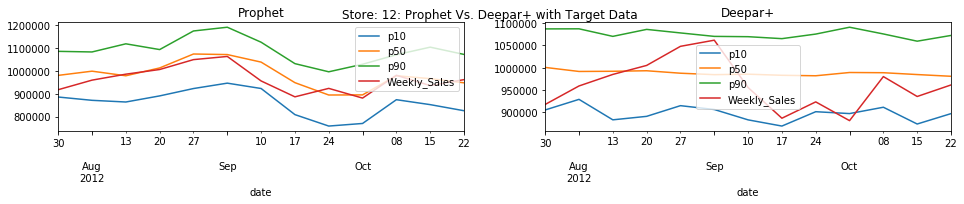

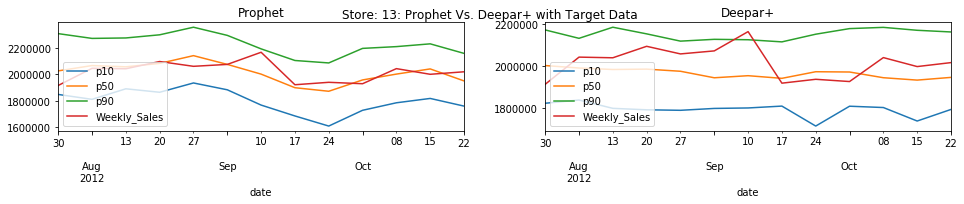

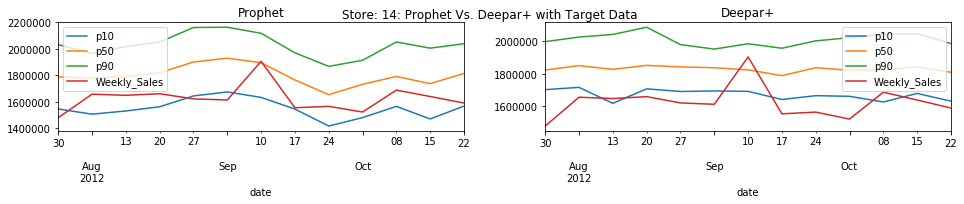

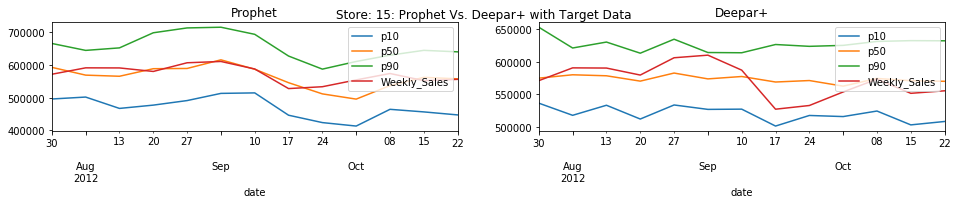

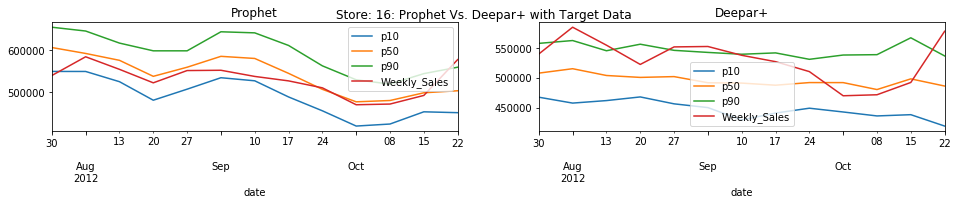

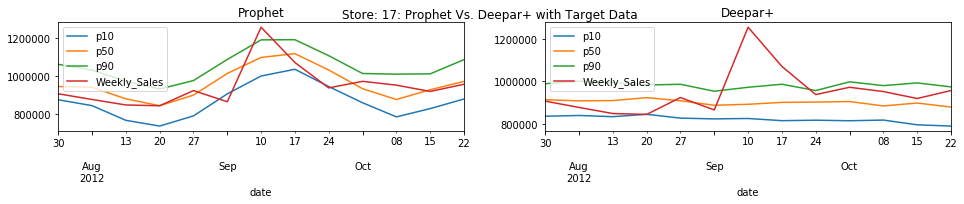

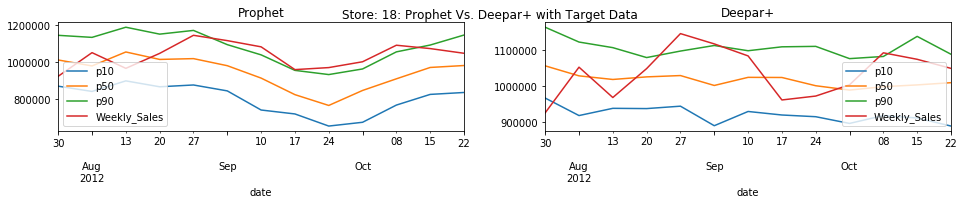

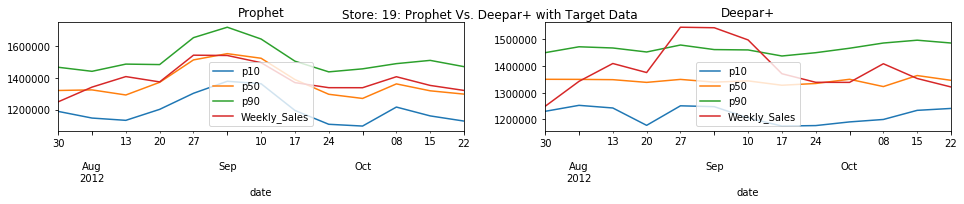

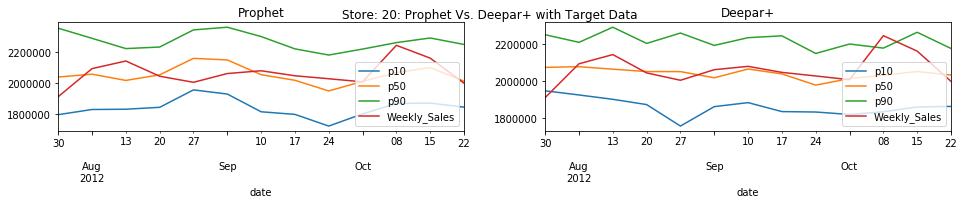

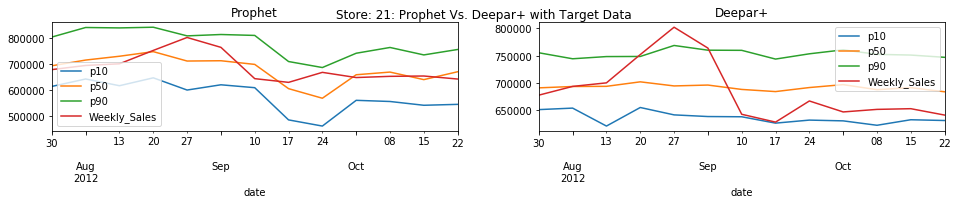

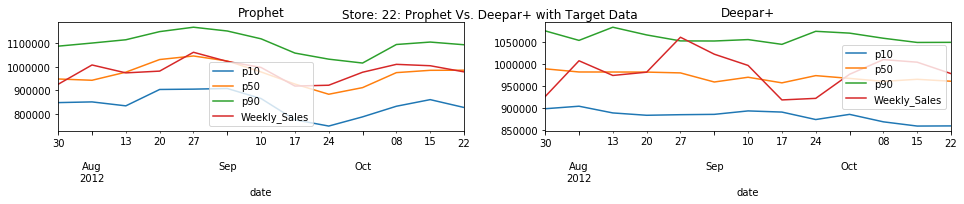

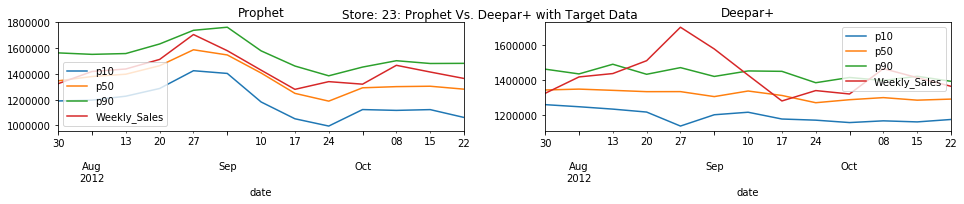

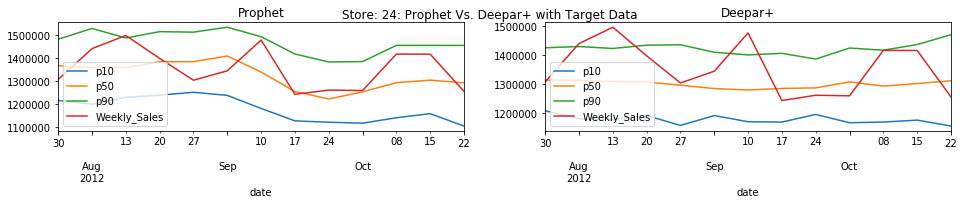

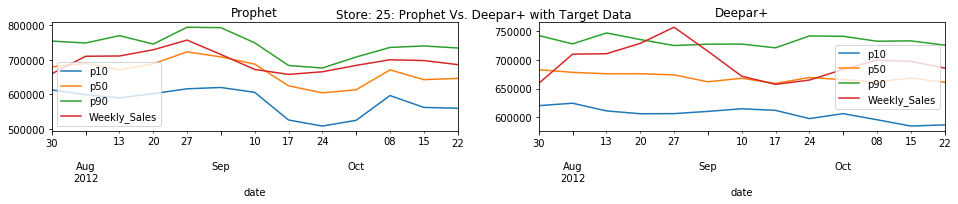

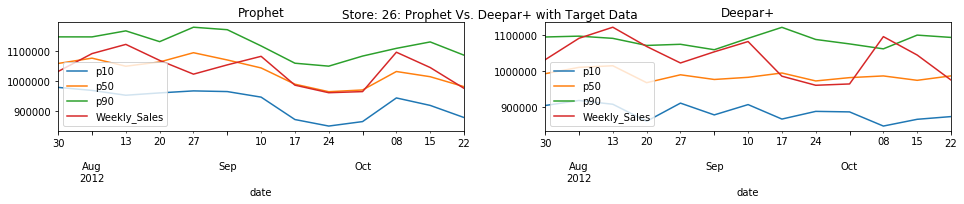

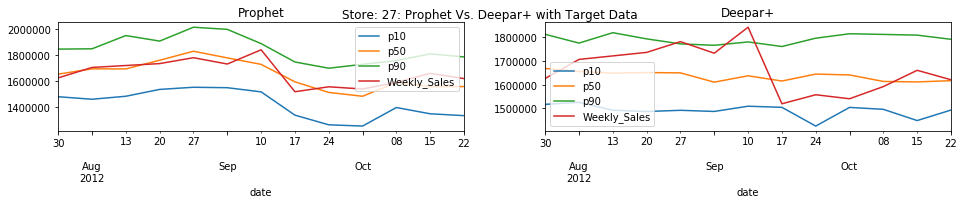

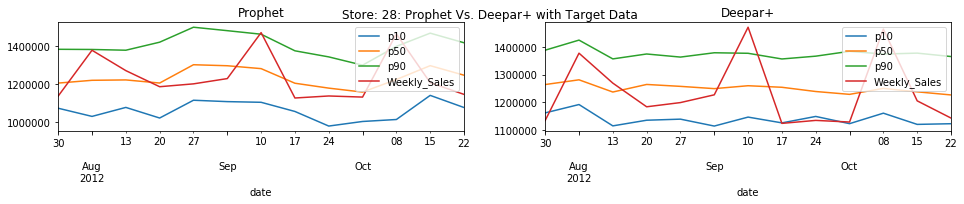

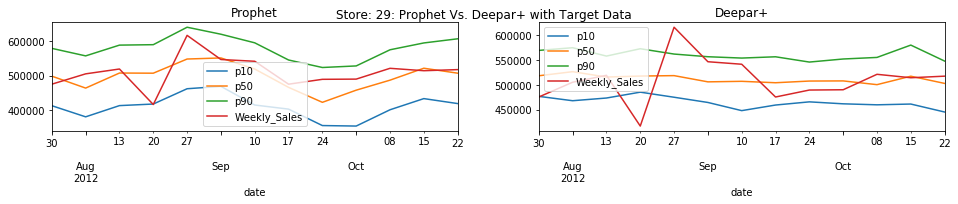

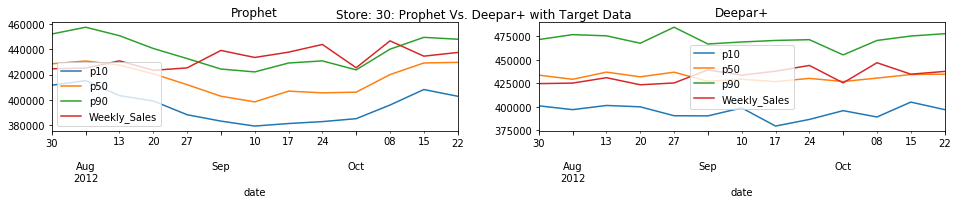

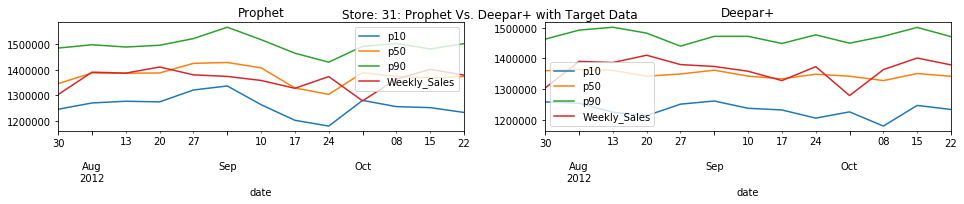

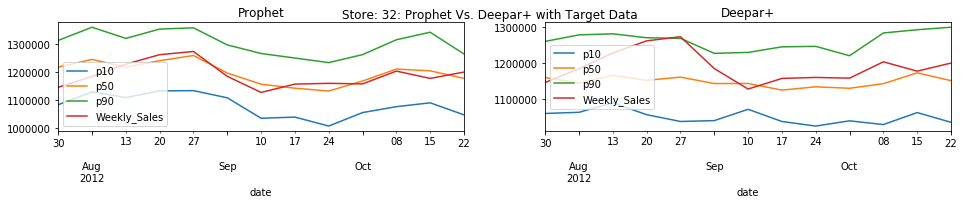

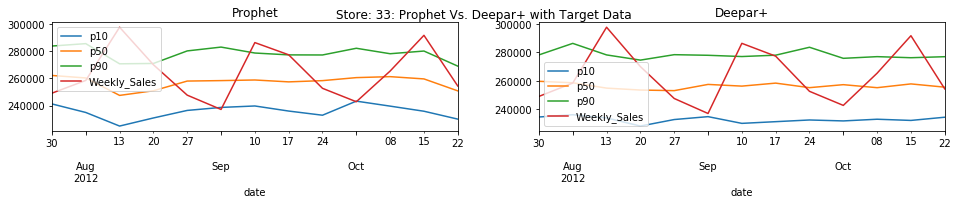

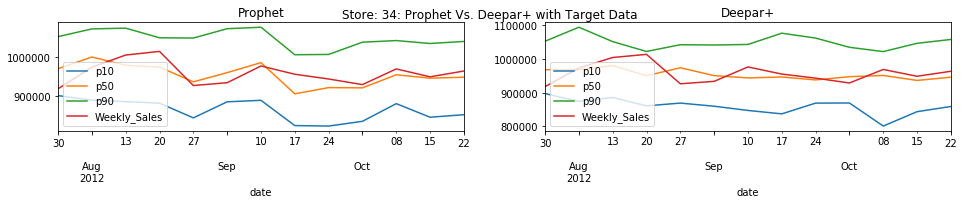

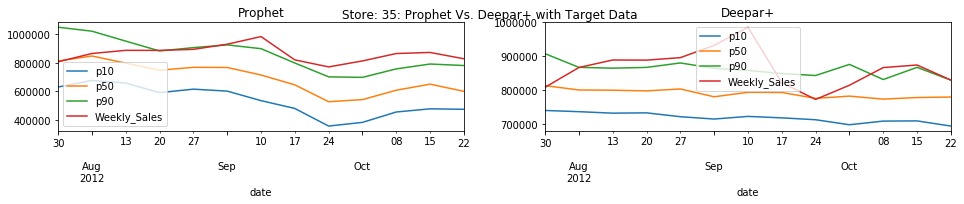

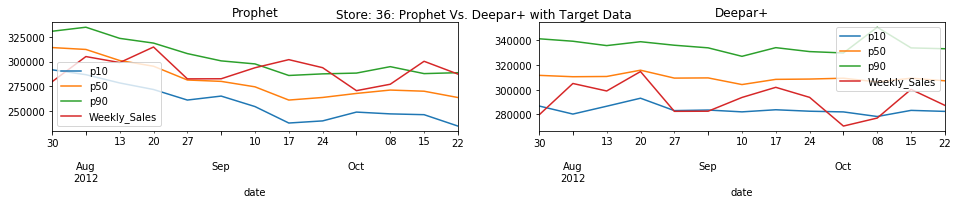

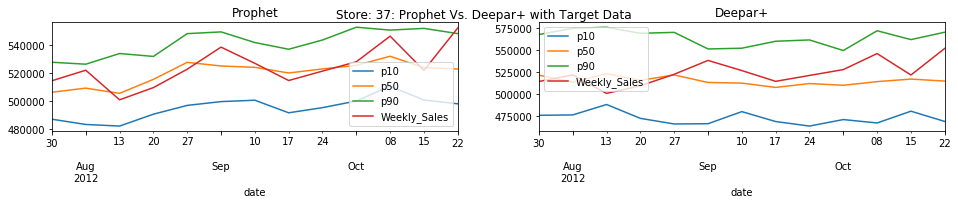

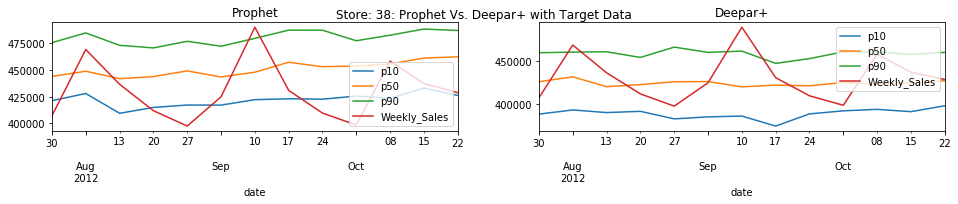

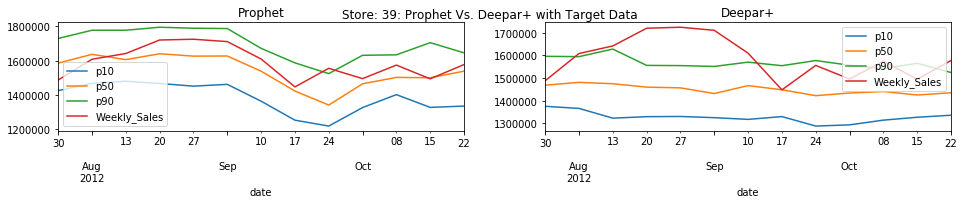

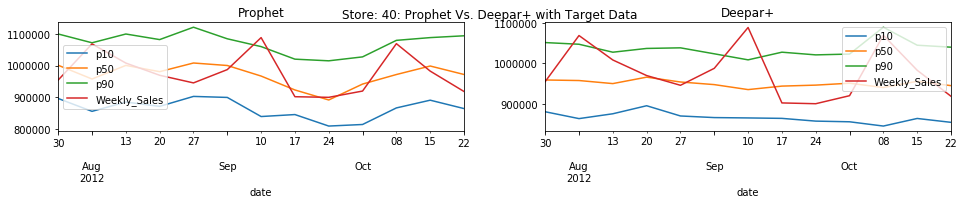

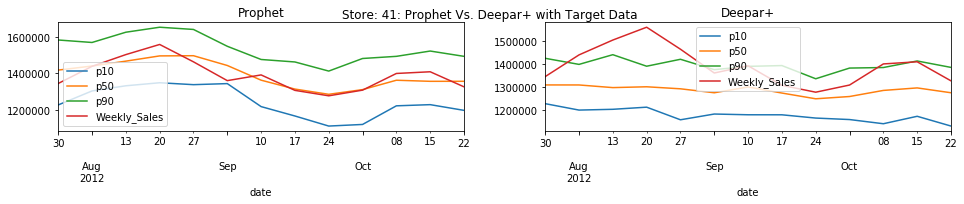

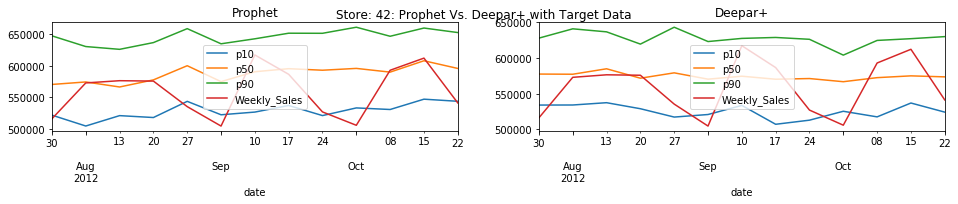

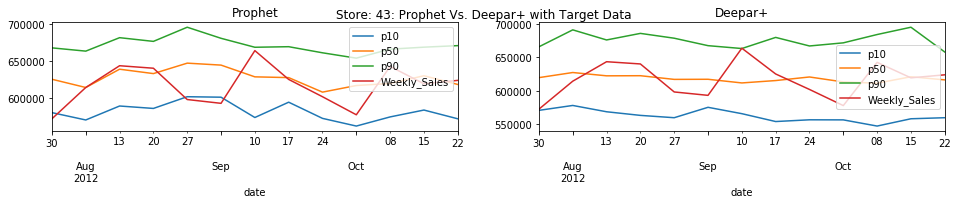

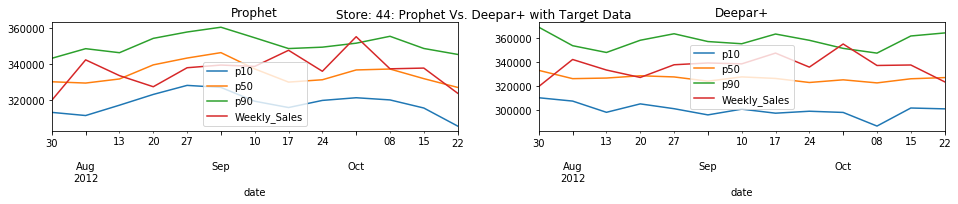

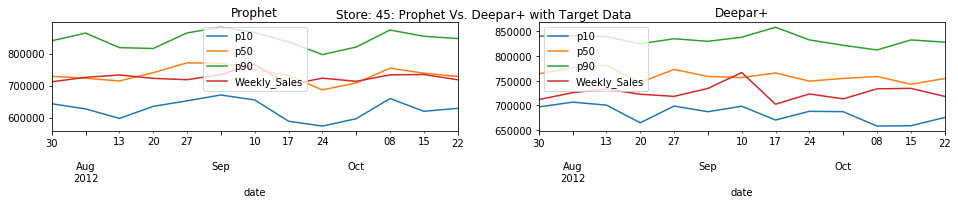

In [36]:
itme_id_list = prophet_val_df.item_id.unique()
itme_id_list = pd.DataFrame(itme_id_list, columns=['item_id'])
itme_id_list.item_id = itme_id_list.item_id.astype('int64')
itme_id_list.item_id.sort_values()

for i in itme_id_list.item_id.sort_values():
    prophet_val_single_df = prophet_val_df[prophet_val_df.item_id == str(i)]
    deeparp_val_single_df = deeparp_val_df[deeparp_val_df.item_id == str(i)]    
    plot_title = "Store: " + str(i) + ": Prophet Vs. Deepar+ with Target Data"
    show_two_chart_horizontal(plot_title, 
                          prophet_val_single_df, 
                          "Prophet", 
                          deeparp_val_single_df,
                          "Deepar+", 
                         )